# Imports

In [1]:
import candas as can
import numpy as np
import pandas as pd
import pathlib as pl
import matplotlib as mpl

mpl.use("Cairo")  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns

from candas.test import QuantStudio
from tinydb import TinyDB

import gumbi as gmb

In [2]:
code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

fig_num = 3
plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

## Global Figure Parameters

In [27]:
width = 1.625
height = 1.85  # 1.65
figsize = (width, height)
spotsize = 8**2
linewidth = 2
ticklabelsize = 8
labelsize = 10
titlesize = labelsize + 2

palette = sns.diverging_palette(20, 220, as_cmap=True)


def format_ax(
    ax,
    title="",
    xlabel="",
    ylabel="FAM$-$HEX",
    figsize=figsize,
    mar_l=0.56,
    mar_r=0.17,
    mar_t=0.22,
    mar_b=0.48 + (height- 1.65),
    ticklabelsize=ticklabelsize,
    labelsize=labelsize,
    titlesize=titlesize,
    **kwargs,
):
    ax.set_xticks(np.arange(0, 8.5, 2))

    ax.set_ylabel(ylabel, fontsize=labelsize)
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_xticks(np.arange(0, 8.5, 2))
    ax.set_title(title, fontsize=titlesize)

    ax.tick_params(axis="both", labelsize=ticklabelsize)

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
        **kwargs,
    )
    plt.setp(ax.spines.values(), linewidth=1)

    ax.axhline(0, lw=1, color="k", zorder=-10)
    ax.set_ylim([-1.1, 1.1])
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])

    return ax


from utils import savefig

In [4]:
hue = "FAM-HEX"
norm = mpl.colors.Normalize(vmin=-1, vmax=+1)

## JG034: Bipartite Module

### Import Data

In [5]:
cmax = 50

file = data_pth / "JG034 TMCC1 Gen2 Competitors - 59C v3.xlsx"
JG034 = (
    QuantStudio(file, "JG034")
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)  # , method='min-max')
    .invert_fluorophore("HEX")
)

# for oligo in ['S036.5', 'S057.3.2', 'S057.4.2']:
#     JG071B.reactions.data['lg10 ' + oligo] = np.log10(JG071B.reactions.data[oligo])

### Plot curves for config of interest 

Saving fig_3Ai__plastic_yak in /home/john/projects/can-manuscript/fig_3__wool_wren/graphics: [.svg] [.png] done


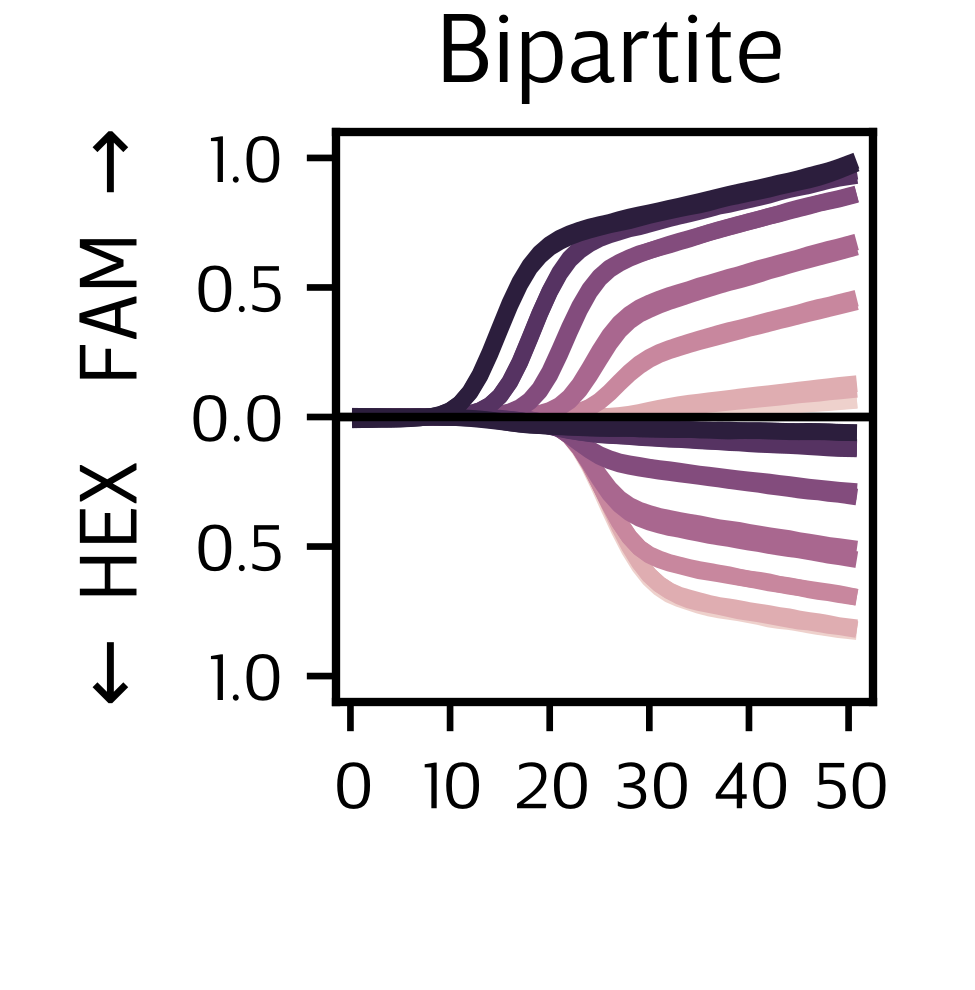

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

this = JG034.reactions.data[
    (JG034.reactions.data["Cycle"] <= cmax)
    & (JG034.reactions.data.Target.str.contains("GC55"))
]

hue = "lg10_Copies"

g = sns.lineplot(
    data=this,
    x="Cycle",
    y="Fluorescence",
    hue=hue,
    palette="ch:0",
    units="Reaction",
    estimator=None,
    legend=False,
    lw=2,
)
ax.axhline(0, lw=1, color="k")
format_ax(
    ax, title="Bipartite", xlabel="", ylabel=r"$\leftarrow$ HEX    FAM $\rightarrow$"
)

ax.set_xticks(np.arange(0, cmax + 1, 10))
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticklabels([1.0, 0.5, 0.0, 0.5, 1.0])

savefig(fig, alias="plastic_yak")

### Fit GP to whole dataset

In [7]:
(
    JG034.invert_fluorophore("HEX")
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore("HEX")
)

JG034.reactions.neaten()
JG034.extract_endpoints(cmax=cmax, name="FAM-HEX")

ds = gmb.DataSet(JG034.endpoints, outputs=["FAM-HEX"])

gp_34 = gmb.GP(ds).fit(
    continuous_dims=["lg10_Copies"],
    # linear_dims = ['lg10_Copies'],
    categorical_dims=["Target"],
)

### Plot endpoint signal for config of interest 

Saving fig_3Aii__ceramic_zebu in /home/john/projects/can-manuscript/fig_3__wool_wren/graphics: [.svg] [.png] done


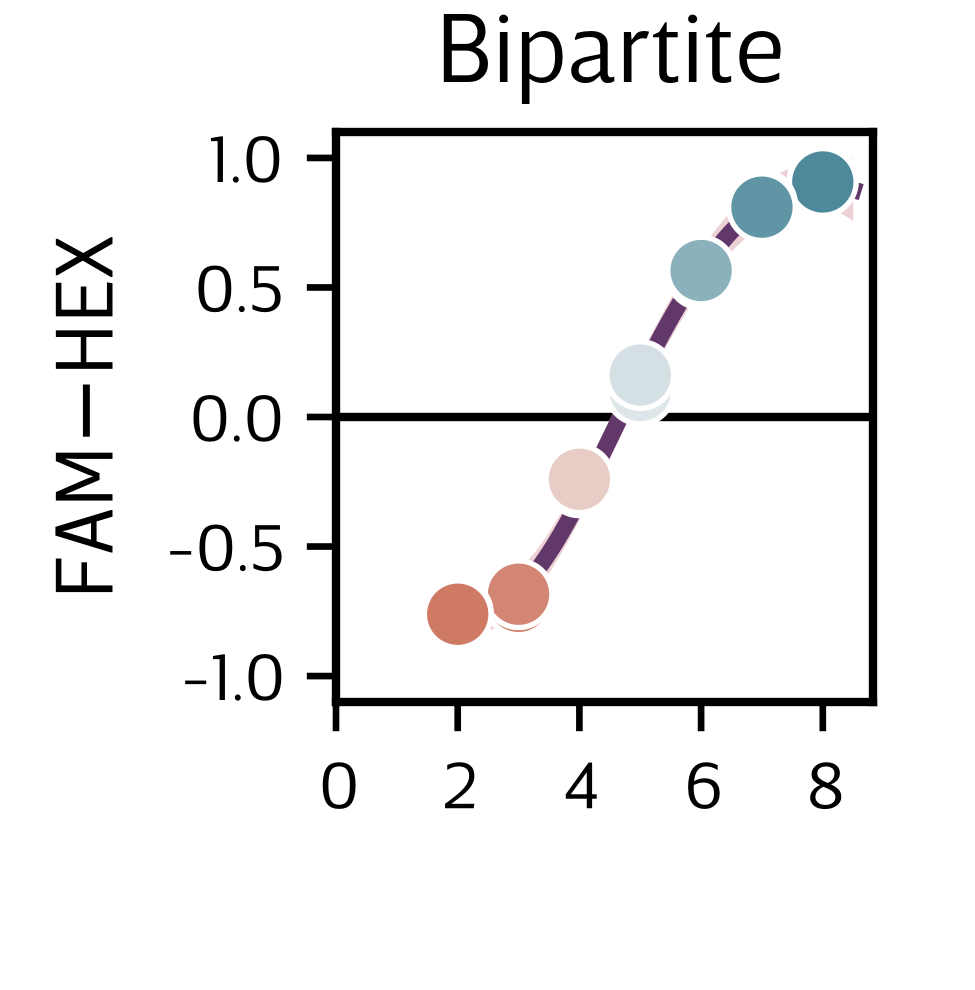

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

endpoints = JG034.endpoints

this = endpoints[
    (endpoints.Reporter == "FAM") & (endpoints.Target.str.contains("GC55"))
]

x_var = "lg10_Copies"
hue = "FAM-HEX"

g = sns.scatterplot(
    data=this,
    x=x_var,
    y=hue,
    hue=hue,
    hue_norm=norm,
    palette=palette,
    s=spotsize,
    legend=False,
)

limits = gp_34.parray(**{x_var: [2.0, 8.5]})
X = gp_34.prepare_grid(limits=limits)[x_var]
y = gp_34.predict_grid(with_noise=False, categorical_levels={"Target": "GC55 - FAM"})

pp = gmb.ParrayPlotter(x=X, y=y)
pp.plot()

# ax.axhline(0, lw=1, color='k')
format_ax(ax, title="Bipartite", xlabel="")
ax.set_ylim([-1.1, 1.1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])

savefig(fig, alias="ceramic_zebu")

## JG071B: Tripartite Module

### Import Data

In [9]:
db_file = data_pth / "JG071B Reaction Specifications.json"
rxn_db = TinyDB(db_file)
rxns = pd.DataFrame([rxn["oligos"] | {"Sample": rxn["name"]} for rxn in rxn_db.all()])

In [10]:
cmax = 50

file = data_pth / "JG071B Tripartite sweep GBP6.xlsx"
JG071B = (
    QuantStudio(file, "JG071B")
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)  # , method='min-max')
    .invert_fluorophore("HEX")
)

JG071B.reactions.data = JG071B.reactions.data.merge(rxns)
for oligo in ["S036.5", "S057.3.2", "S057.4.2"]:
    JG071B.reactions.data["lg10 " + oligo] = np.log10(JG071B.reactions.data[oligo])

### Plot curves for config of interest 

Saving fig_3Bi__metal_anchovy in /home/john/projects/can-manuscript/fig_3__wool_wren/graphics: [.svg] [.png] done


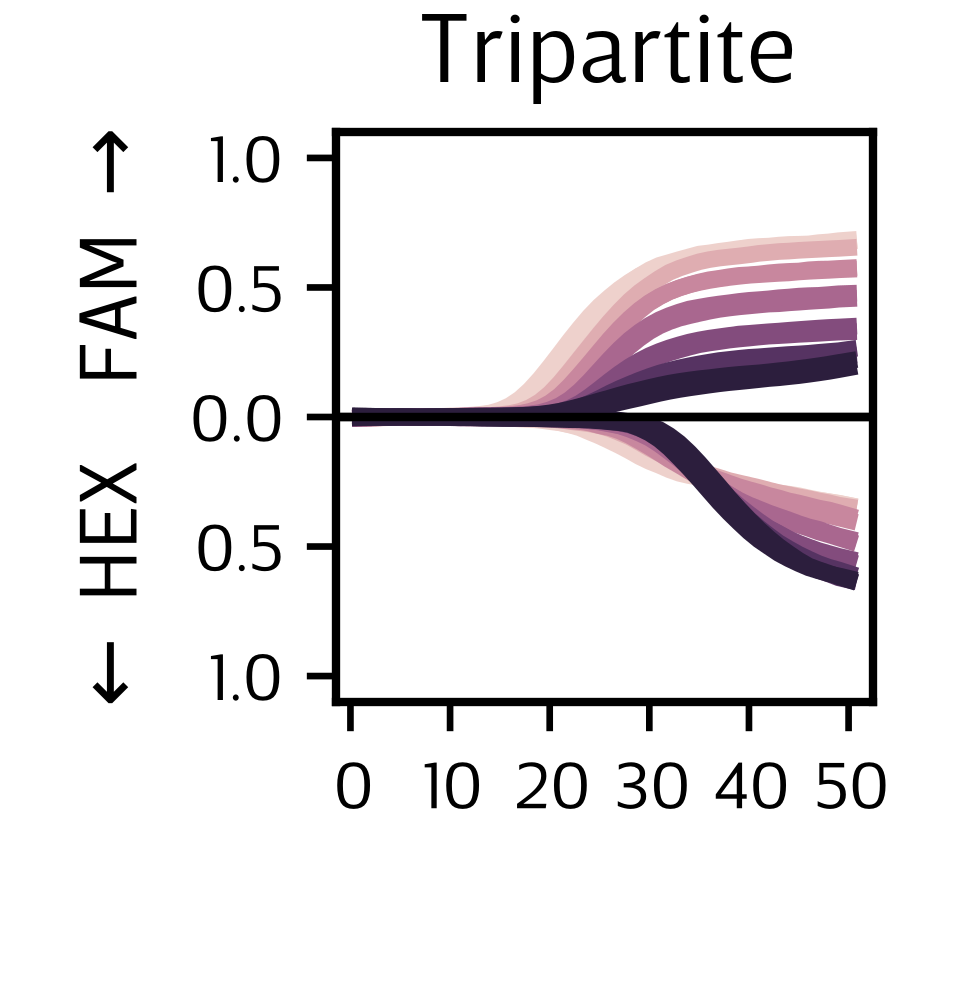

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

this = JG071B.reactions.data[
    (JG071B.reactions.data["Cycle"] <= cmax)
    & (JG071B.reactions.data["lg10 S036.5"] > 1)
    & (JG071B.reactions.data["lg10 S057.3.2"] == 6.0)
    & (JG071B.reactions.data["lg10 S057.4.2"] == 4.0)
]

hue = "lg10 S036.5"

g = sns.lineplot(
    data=this,
    x="Cycle",
    y="Fluorescence",
    hue=hue,
    palette="ch:0",
    units="Reaction",
    estimator=None,
    legend=False,
    lw=2,
)
ax.axhline(0, lw=1, color="k")
format_ax(
    ax, title="Tripartite", xlabel="", ylabel=r"$\leftarrow$ HEX    FAM $\rightarrow$"
)

ax.set_xticks(np.arange(0, cmax + 1, 10))
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticklabels([1.0, 0.5, 0.0, 0.5, 1.0])

savefig(fig, alias="metal_anchovy")

### Fit GP to whole dataset

In [12]:
(
    JG071B.invert_fluorophore("HEX")
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore("HEX")
)

JG071B.reactions.neaten()
JG071B.extract_endpoints(cmax=cmax, name="FAM-HEX")

ds = gmb.DataSet(JG071B.endpoints, outputs=["FAM-HEX"])

gp_71B = gmb.GP(ds).fit(
    continuous_dims=["lg10 S036.5", "lg10 S057.3.2", "lg10 S057.4.2"],
    linear_dims=["lg10 S036.5", "lg10 S057.3.2", "lg10 S057.4.2"],
)

### Plot endpoint signal for config of interest 

Saving fig_3Bii__digital_bear in /home/john/projects/can-manuscript/fig_3__wool_wren/graphics: [.svg] [.png] done


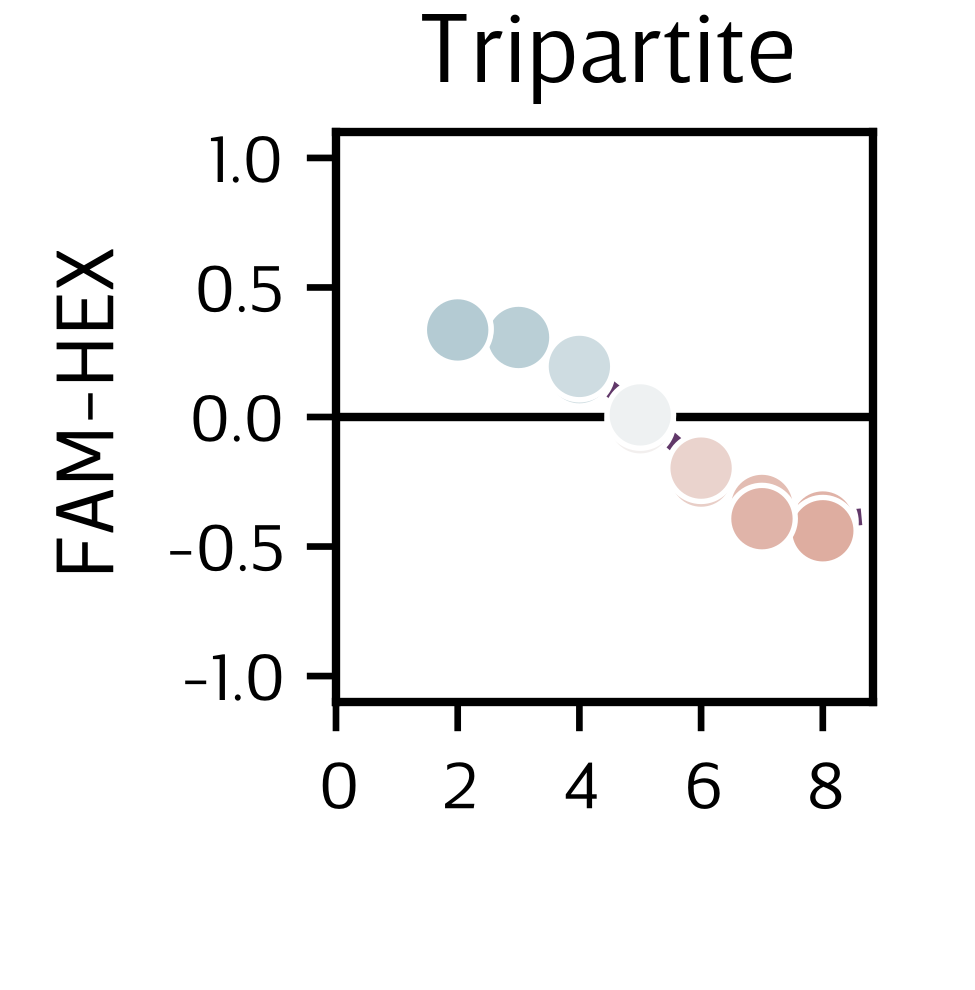

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

endpoints = JG071B.endpoints

this = endpoints[
    (endpoints.Reporter == "FAM")
    & (endpoints["lg10 S036.5"] > 1)
    & (endpoints["lg10 S057.3.2"] == 6.0)
    & (endpoints["lg10 S057.4.2"] == 4.0)
]

hue = "FAM-HEX"

g = sns.scatterplot(
    data=this,
    x="lg10 S036.5",
    y=hue,
    hue=hue,
    hue_norm=norm,
    palette=palette,
    s=spotsize,
    legend=False,
    ax=ax,
)

at = gp_71B.parray(**{"lg10 S057.3.2": 6.0, "lg10 S057.4.2": 4.0})
limits = gp_71B.parray(**{"lg10 S036.5": [2.0, 8.5]})
X = gp_71B.prepare_grid(at=at, limits=limits)["lg10 S036.5"]
y = gp_71B.predict_grid(with_noise=False)

pp = gmb.ParrayPlotter(x=X, y=y)
pp.plot()

format_ax(ax, title="Tripartite", ylabel="FAM-HEX", xlabel="")
# ax.set_yticks([-0.5, 0, 0.5])

savefig(fig, alias="digital_bear")

## JG074C: Antiparallel Redundant Module

### Import Data

In [14]:
db_file = data_pth / "JG074C Reaction Specifications.json"
rxn_db = TinyDB(db_file)
rxns = pd.DataFrame([rxn["oligos"] | {"Sample": rxn["name"]} for rxn in rxn_db.all()])

In [15]:
cmax = 50

file = data_pth / "JG074C_L2_500_competitor_sweep.xlsx"
JG074C = (
    QuantStudio(file, "JG074C")
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)  # , method='min-max')
    .invert_fluorophore("HEX")
)

JG074C.reactions.data = JG074C.reactions.data.merge(rxns)
for oligo in ["L2_500", "S037.01.01b", "S036.1b"]:
    JG074C.reactions.data["lg10 " + oligo] = np.log10(JG074C.reactions.data[oligo])

# One competitor was clearly missing from this mastermix
JG074C.reactions.wide = JG074C.reactions.wide[
    ~(
        (JG074C.reactions.wide["lg10 S037.01.01b"] == 8.0)
        & (JG074C.reactions.wide["lg10 S036.1b"] == 2.0)
    )
]

### Plot curves for config of interest 

Saving fig_3Ci__electric_chinchilla in /home/john/projects/can-manuscript/fig_3__wool_wren/graphics: [.svg] [.png] done


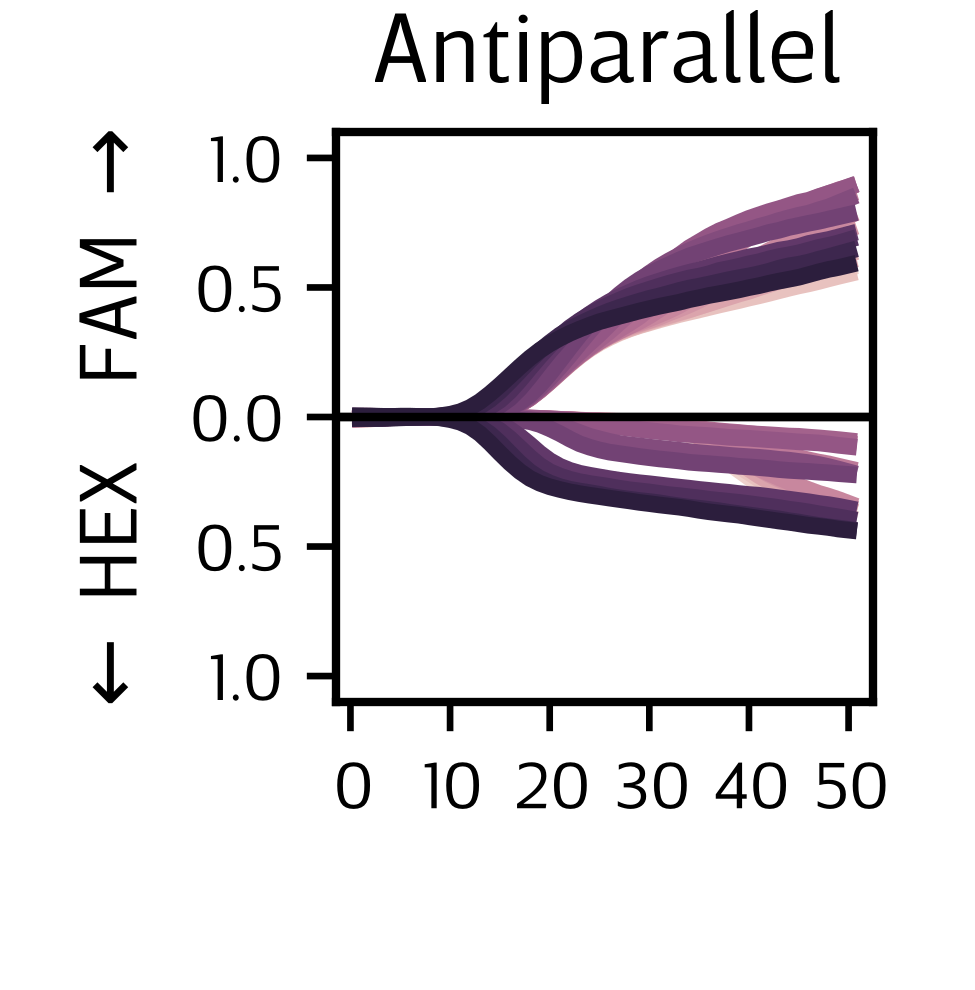

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))


this = JG074C.reactions.data[
    (JG074C.reactions.data["Cycle"] <= cmax)
    &
    #     (JG074C.reactions.data.Reporter=='FAM') &
    (JG074C.reactions.data["lg10 S037.01.01b"] == 6.0)
    & (JG074C.reactions.data["lg10 S036.1b"] == 2.0)
]

hue = "lg10 L2_500"

g = sns.lineplot(
    data=this,
    x="Cycle",
    y="Fluorescence",
    hue=hue,
    palette="ch:0",
    units="Reaction",
    estimator=None,
    legend=False,
    lw=2,
)
ax.axhline(0, lw=1, color="k")
format_ax(
    ax, title="Antiparallel", xlabel="", ylabel=r"$\leftarrow$ HEX    FAM $\rightarrow$"
)

ax.set_xticks(np.arange(0, cmax + 1, 10))
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticklabels([1.0, 0.5, 0.0, 0.5, 1.0])

panel = "C"
subpanel = "i"

savefig(fig, alias="electric_chinchilla")

### Fit GP to whole dataset

In [17]:
(
    JG074C.invert_fluorophore("HEX")
    .normalize_reactions(cmax=cmax, method="min-max")
    .invert_fluorophore("HEX")
)
JG074C.reactions.neaten()
JG074C.extract_endpoints(cmax=cmax, method="bipolar", name="FAM-HEX")

ds = gmb.DataSet(JG074C.endpoints, outputs=["FAM-HEX"])

gp_74C = gmb.GP(ds).fit(
    continuous_dims=["lg10 L2_500", "lg10 S037.01.01b", "lg10 S036.1b"]
)

### Plot endpoint signal for config of interest 

In [18]:
hue = "FAM-HEX"
norm = mpl.colors.Normalize(vmin=-1, vmax=+1)

Saving fig_3Cii__solar_dog in /home/john/projects/can-manuscript/fig_3__wool_wren/graphics: [.svg] [.png] done


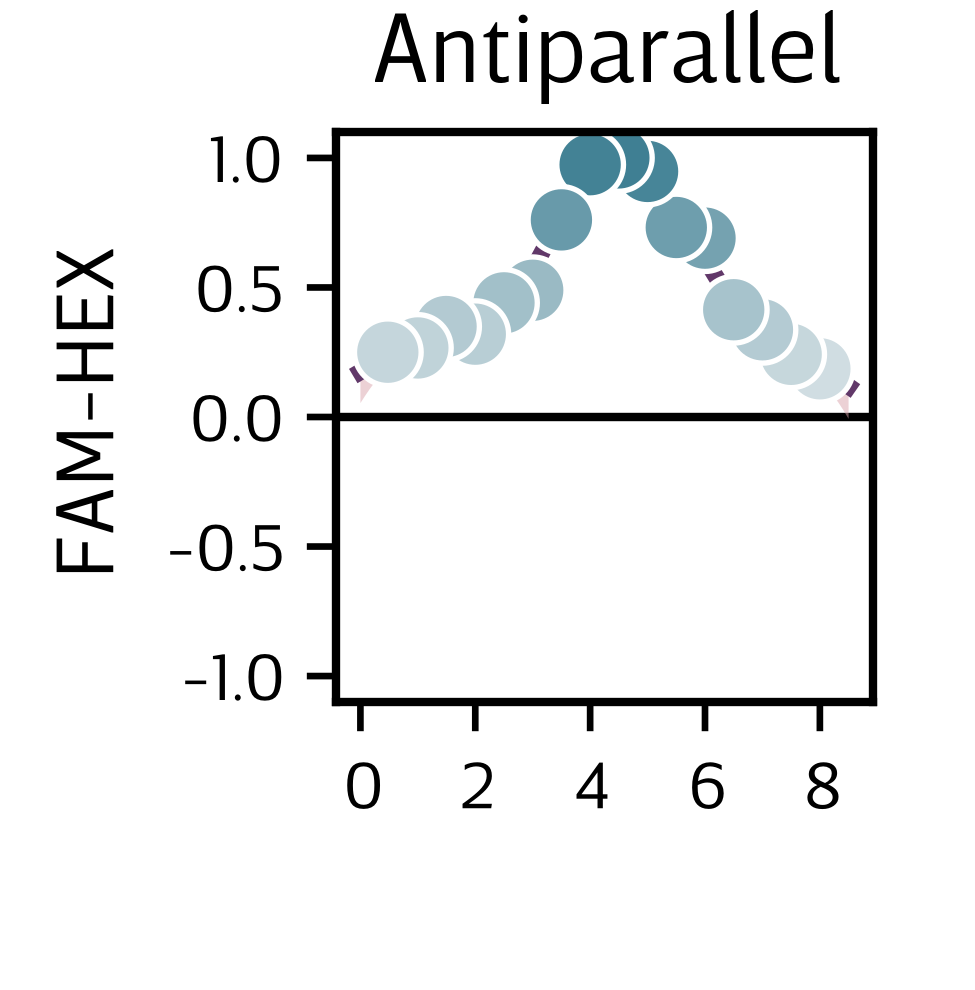

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

this = JG074C.endpoints[
    (JG074C.endpoints.Reporter == "FAM")
    &
    #     (JG074C.endpoints['lg10 L2_500'] > 1) &
    (JG074C.endpoints["lg10 S037.01.01b"] == 6.0)
    & (JG074C.endpoints["lg10 S036.1b"] == 2.0)
]

hue = "FAM-HEX"

g = sns.scatterplot(
    data=this,
    x="lg10 L2_500",
    y=hue,
    hue=hue,
    palette=palette,
    hue_norm=norm,
    s=spotsize,
    legend=False,
)


at = gp_74C.parray(**{"lg10 S037.01.01b": 6.0, "lg10 S036.1b": 2.0})
limits = gp_74C.parray(**{"lg10 L2_500": [0, 8.5]})
X = gp_74C.prepare_grid(at=at, limits=limits)["lg10 L2_500"]
y = gp_74C.predict_grid(with_noise=False)

pp = gmb.ParrayPlotter(x=X, y=y)
pp.plot()

format_ax(ax, title="Antiparallel", ylabel="FAM-HEX", xlabel="")
# ax.set_yticks([0, 0.5, 1])

savefig(fig, alias="solar_dog")

## JG074D: Parallel Redundant Module

### Import Data

In [20]:
db_file = data_pth / "JG074D Reaction Specifications.json"
rxn_db = TinyDB(db_file)
rxns = pd.DataFrame([rxn["oligos"] | {"Sample": rxn["name"]} for rxn in rxn_db.all()])

In [21]:
cmax = 50

file = data_pth / "JG074D_L2_500_like_competitor_sweep.xlsx"
JG074D = (
    QuantStudio(file, "JG074D")
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore("HEX")
)

JG074D.reactions.data = JG074D.reactions.data.merge(rxns)
for oligo in ["L2_500_like", "S037.01.01b", "S036.0"]:
    JG074D.reactions.data["lg10 " + oligo] = np.log10(JG074D.reactions.data[oligo])

### Plot curves for config of interest 

Saving fig_3Di__lunar_earwig in /home/john/projects/can-manuscript/fig_3__wool_wren/graphics: [.svg] [.png] done


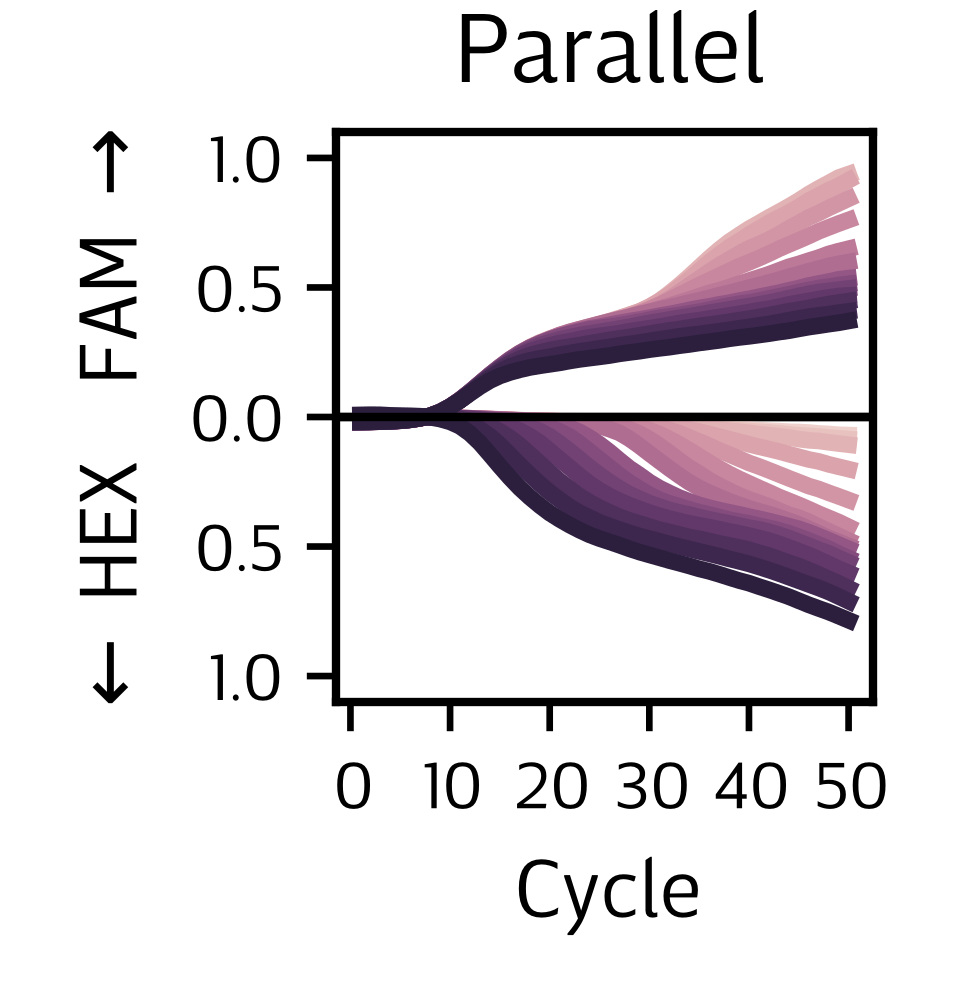

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

this = JG074D.reactions.data[
    (JG074D.reactions.data["Cycle"] <= cmax)
    &
    #     (JG074D.reactions.data.Reporter=='FAM') &
    (JG074D.reactions.data["lg10 S037.01.01b"] == 8.0)
    & (JG074D.reactions.data["lg10 S036.0"] == 2.0)
]

hue = "lg10 L2_500_like"

g = sns.lineplot(
    data=this,
    x="Cycle",
    y="Fluorescence",
    hue=hue,
    palette="ch:0",
    units="Reaction",
    estimator=None,
    legend=False,
    lw=2,
)
plt.gca().axhline(0, lw=1, color="k")

format_ax(
    ax,
    title="Parallel",
    xlabel="Cycle",
    ylabel=r"$\leftarrow$ HEX    FAM $\rightarrow$",
)

ax.set_xticks(np.arange(0, cmax + 1, 10))
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticklabels([1.0, 0.5, 0.0, 0.5, 1.0])

savefig(fig, alias="lunar_earwig")

### Fit GP to whole dataset

In [23]:
(
    JG074D.invert_fluorophore("HEX")
    .normalize_reactions(cmax=cmax, method="min-max")
    .invert_fluorophore("HEX")
)

JG074D.reactions.neaten()
JG074D.extract_endpoints(cmax=cmax, method="bipolar", name="FAM-HEX")

ds = gmb.DataSet(JG074D.endpoints, outputs=["FAM-HEX"])

gp_74D = gmb.GP(ds).fit(
    continuous_dims=["lg10 L2_500_like", "lg10 S037.01.01b", "lg10 S036.0"]
)

### Plot endpoint signal for config of interest 

Saving fig_3Dii__cosmic_falcon in /home/john/projects/can-manuscript/fig_3__wool_wren/graphics: [.svg] [.png] done


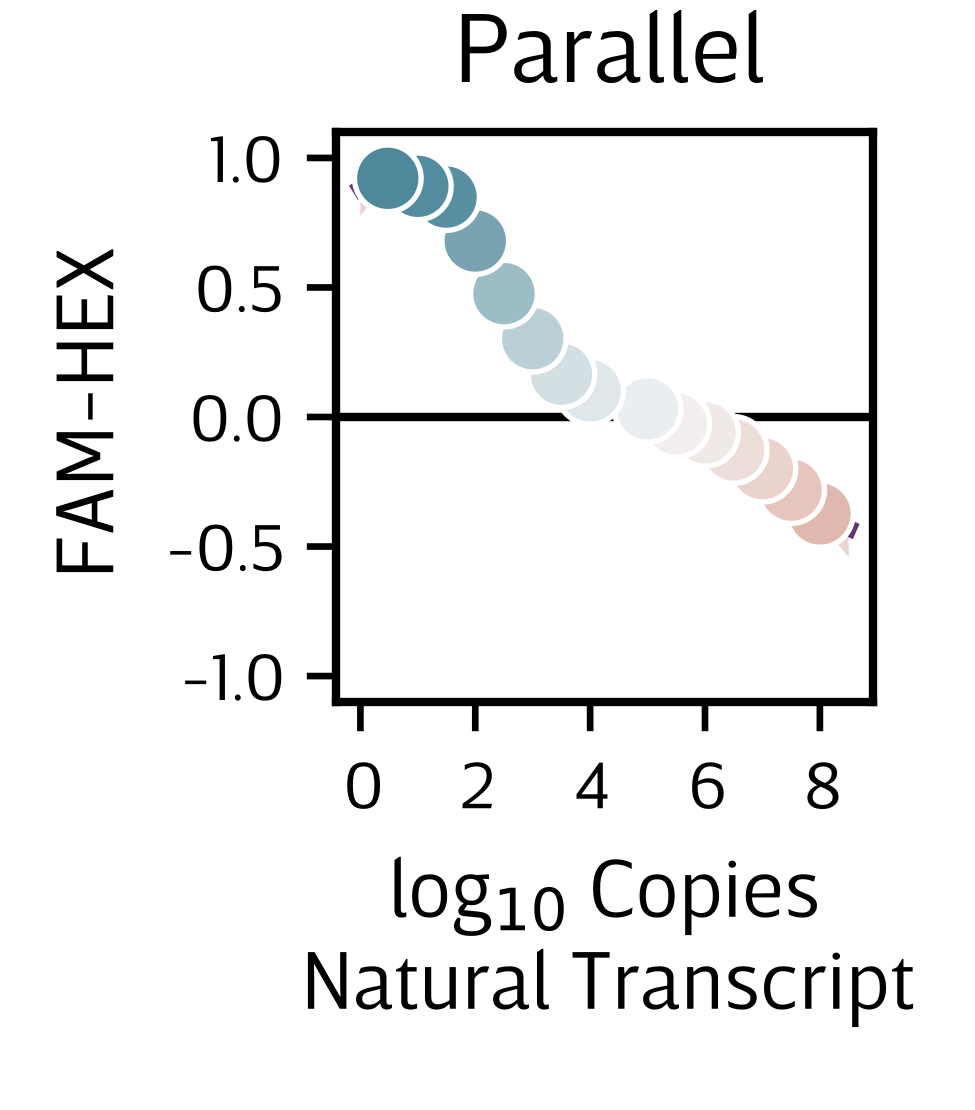

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

this = JG074D.endpoints[
    (JG074D.endpoints.Reporter == "FAM")
    &
    #     (JG074D.endpoints['lg10 L2_500_like'] > 1) &
    (JG074D.endpoints["lg10 S037.01.01b"] == 8.0)
    & (JG074D.endpoints["lg10 S036.0"] == 2.0)
]

hue = "FAM-HEX"

g = sns.scatterplot(
    data=this,
    x="lg10 L2_500_like",
    y=hue,
    hue=hue,
    hue_norm=norm,
    palette=palette,
    s=spotsize,
    legend=False,
)

at = gp_74D.parray(**{"lg10 S037.01.01b": 8.0, "lg10 S036.0": 2.0})
limits = gp_74D.parray(**{"lg10 L2_500_like": [0, 8.5]})
X = gp_74D.prepare_grid(at=at, limits=limits)["lg10 L2_500_like"]
y = gp_74D.predict_grid(with_noise=False)

pp = gmb.ParrayPlotter(x=X, y=y)
pp.plot()

format_ax(ax, title="Parallel", ylabel="FAM-HEX", xlabel='log$_{10}$ Copies\nNatural Transcript')

savefig(fig, alias="cosmic_falcon", display_width_inches=0.5)